In [1]:
import sys
import gc

import fastai
from fastai.vision.all import *
from timm import create_model

from efficientnet_pytorch import EfficientNet

In [2]:
SEED=42
BATCH_SIZE = 32

set_seed(SEED, reproducible=True)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

In [3]:
dataset_path = Path('../input/MMU2/')

In [4]:
fnames = get_image_files(dataset_path)

In [5]:
def label_func(x): return x.parent.name

In [6]:
dls = ImageDataLoaders.from_path_func(dataset_path, 
                                      fnames, 
                                      label_func,
                                      seed=SEED,
                                      bs=BATCH_SIZE,
                                      num_workers=8,
                                      item_tfms=[Resize((224), method=ResizeMethod.Crop)], #pass in item_tfms
                                      batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) #pass in batch_tfms

In [7]:
dls.c

100

In [8]:
# model = create_model('swin_large_patch4_window7_224', pretrained=True, num_classes=dls.c)
model = create_model('efficientnet_b0', pretrained=True, num_classes=dls.c)

In [9]:
learn = Learner(dls, 
                model,
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropyFlat(), 
                metrics=accuracy)

SuggestedLRs(valley=0.0008317637839354575)

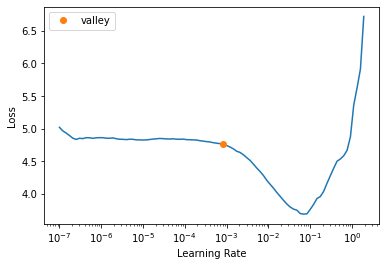

In [10]:
learn.lr_find()

In [11]:
learn.fit_one_cycle(n_epoch = 3, 
                lr_max  = 1e-3, 
                div     = 5,
                pct_start=0.0)

learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time
0,4.565670,4.641436,0.015075,00:10
1,3.881176,4.247974,0.115578,00:10
2,3.359772,3.791980,0.281407,00:10


epoch,train_loss,valid_loss,accuracy,time
0,2.734485,3.238823,0.502513,00:10
1,2.649297,3.027961,0.562814,00:10
2,2.512558,2.818584,0.628141,00:10
3,2.339505,2.591033,0.668342,00:10
4,2.153031,2.353157,0.763819,00:10
5,1.968815,2.130370,0.824121,00:10
6,1.791190,1.957628,0.849246,00:10
7,1.618967,1.778827,0.894472,00:10
8,1.477392,1.629947,0.914573,00:10
9,1.349970,1.514547,0.934673,00:10


Better model found at epoch 0 with valid_loss value: 3.2388229370117188.
Better model found at epoch 1 with valid_loss value: 3.0279605388641357.
Better model found at epoch 2 with valid_loss value: 2.8185839653015137.
Better model found at epoch 3 with valid_loss value: 2.591033458709717.
Better model found at epoch 4 with valid_loss value: 2.353156805038452.
Better model found at epoch 5 with valid_loss value: 2.1303703784942627.
Better model found at epoch 6 with valid_loss value: 1.9576283693313599.
Better model found at epoch 7 with valid_loss value: 1.77882719039917.
Better model found at epoch 8 with valid_loss value: 1.6299471855163574.
Better model found at epoch 9 with valid_loss value: 1.5145466327667236.
Better model found at epoch 10 with valid_loss value: 1.429649829864502.
Better model found at epoch 11 with valid_loss value: 1.368080735206604.
Better model found at epoch 12 with valid_loss value: 1.320380449295044.
Better model found at epoch 13 with valid_loss value: 1

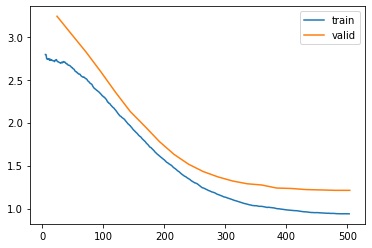

In [12]:
learn.fit_one_cycle(n_epoch=21, 
                    lr_max=slice(1e-7,1e-4), 
                    div=50, 
                    pct_start=0.0, 
                    cbs = [
                           SaveModelCallback(fname=f'best_model',monitor='valid_loss'),
                           EarlyStoppingCallback(monitor='valid_loss', comp=np.less, patience=5),
                           ReduceLROnPlateau(monitor='valid_loss', 
                                             min_delta=0.1, 
                                             patience = 3, 
                                             min_lr = 1e-8)])

learn.recorder.plot_loss()

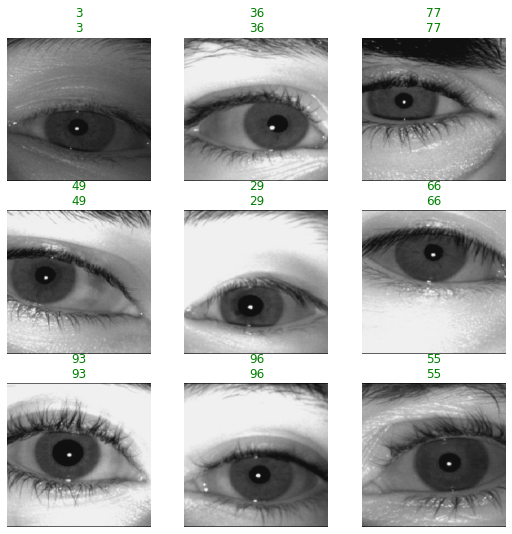

In [14]:
learn.show_results()

In [17]:
learn = learn.to_fp32()

learn.export(f'./model_EffiNetB0_0.964824.pkl')
learn.save(f'./model_EffiNetB0_0.964824.pkl')

Path('../input/MMU2/models/model_EffiNetB0_0.964824.pkl.pth')

In [18]:
del learn

torch.cuda.empty_cache()

gc.collect()

25826